To-Do:
- Measure the performance of models on both sets
- Check Nonsense

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

seeds = [11, 12, 13, 14, 15, 42, 81, 93, 188, 830]

# Plot

In [2]:
full_preds = {}
for seed in seeds:
    full_pred_path = os.path.join("/reef/sqt2/TraMa_Exp/Full-SinglePreds/train-cmv/roberta-large/", "seed-{}".format(seed), "test-cmv/full/test_predictions.csv")
    full_preds[seed] = pd.read_csv(full_pred_path, index_col=0)
single_preds = {}
for seed in seeds:
    single_pred_path = os.path.join("/reef/sqt2/TraMa_Exp/Full-SinglePreds/train-cmv/roberta-large/", "seed-{}".format(seed), "test-cmv/single/test_predictions.csv")
    single_preds[seed] = pd.read_csv(single_pred_path, index_col=0)

strong_awry_preds = {}
for seed in seeds:
    strong_awry_path = os.path.join("/home/sqt2/myExperiment/cs6742-trama/predictions/strong_awry_utterances", str(seed), "test_predictions.csv")
    strong_awry_preds[seed] = pd.read_csv(strong_awry_path, index_col=0)

weak_awry_preds = {}
for seed in seeds:
    weak_awry_path = os.path.join("/home/sqt2/myExperiment/cs6742-trama/predictions/weak_awry_utterances", str(seed), "test_predictions.csv")
    weak_awry_preds[seed] = pd.read_csv(weak_awry_path, index_col=0)

In [5]:
def get_diff(candidate, reference, indices=None):
    differences = []
    if not indices:
        indices = [i for i in reference[11].index if '_' not in i]
    for index in indices:
        reference_preds = []
        for seed in seeds:
            reference_preds.append(reference[seed]['forecast_prob'][index])
        candidate_preds = []
        for seed in seeds:
            candidate_preds.append(candidate[seed]['forecast_prob'][index])
        diff = (sum(reference_preds) - sum(candidate_preds)) / len(candidate_preds)
        differences.append(diff)
    return differences
def plot_diffs(differences, title):
    counts, bins = np.histogram(differences, bins=100)
    percentages = (counts / counts.sum()) * 100
    plt.hist(bins[:-1], bins, weights=percentages, edgecolor='black')
    plt.xlabel('Difference Values')
    plt.ylabel('Percentage (%)')
    plt.title(title)
    plt.show()
    return

strong_indices = [i for i in strong_awry_preds[11].index if '_' not in i]
strong_fullSingle = get_diff(full_preds, single_preds, strong_indices)

weak_indices = [i for i in weak_awry_preds[11].index if '_' not in i]
weak_fullSingle = get_diff(full_preds, single_preds, weak_indices)

strong_fullTraMa = get_diff(full_preds, strong_awry_preds, strong_indices)
strong_singleTraMa = get_diff(single_preds, strong_awry_preds, strong_indices)

weak_fullTraMa = get_diff(full_preds, weak_awry_preds, weak_indices)
weak_singleTraMa = get_diff(single_preds, weak_awry_preds, weak_indices)


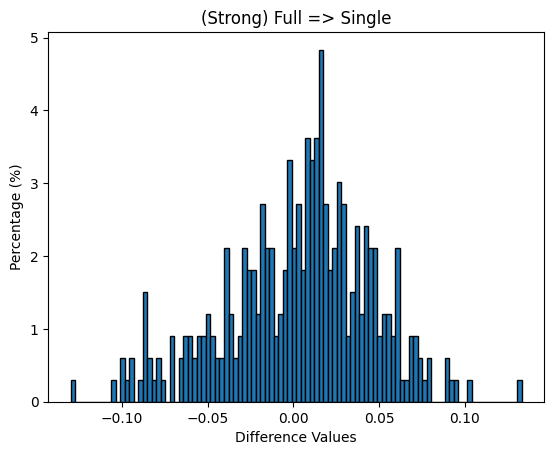

In [6]:
plot_diffs(strong_fullSingle, "(Strong) Full => Single")

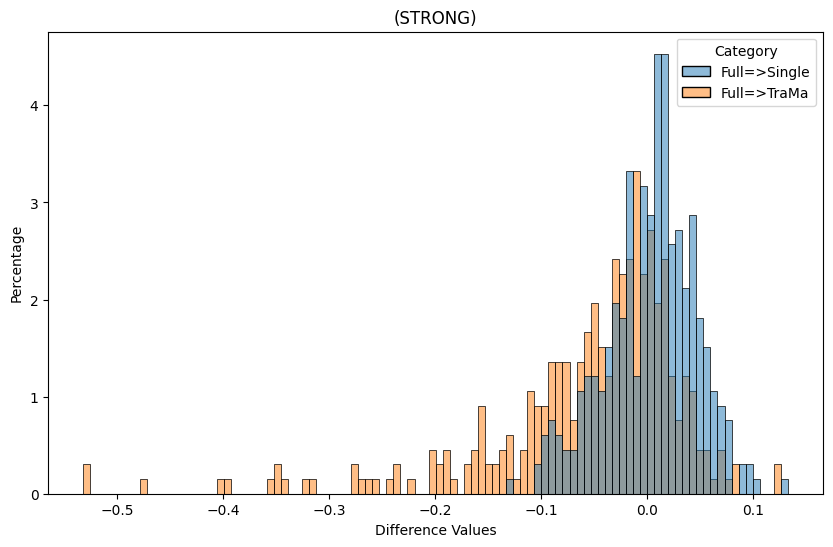

In [7]:
import seaborn as sns
data = pd.DataFrame({
    'Value': strong_fullSingle + strong_fullTraMa,
    'Category': ['Full=>Single'] * len(strong_fullSingle) + ['Full=>TraMa'] * len(strong_fullTraMa)
})

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, x='Value', hue='Category', stat='percent', label='Category', bins=100, kde=False)

# Add labels and title
plt.xlabel('Difference Values')
plt.ylabel('Percentage')
plt.title("(STRONG)")

plt.show()

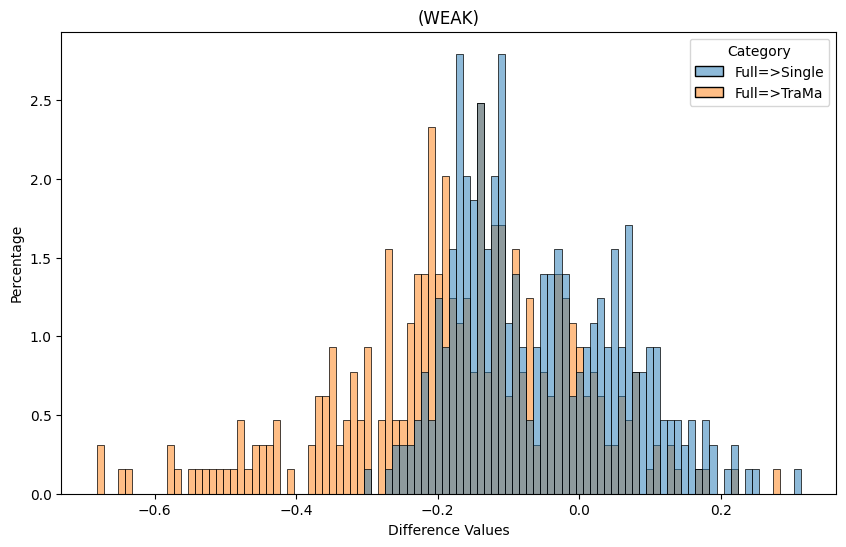

In [8]:
data = pd.DataFrame({
    'Value': weak_fullSingle + weak_fullTraMa,
    'Category': ['Full=>Single'] * len(weak_fullSingle) + ['Full=>TraMa'] * len(weak_fullTraMa)
})

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, x='Value', hue='Category', stat='percent', label='Category', bins=100, kde=False)

# Add labels and title
plt.xlabel('Difference Values')
plt.ylabel('Percentage')
plt.title("(WEAK)")
plt.show()

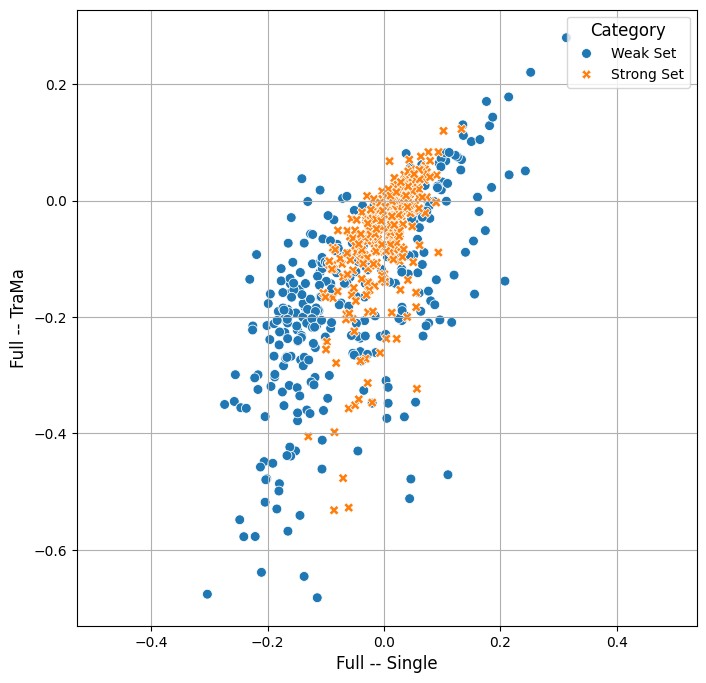

In [10]:
df_weak = pd.DataFrame({
    "x": weak_fullSingle,
    "y": weak_fullTraMa,
    "label": "Weak Set"
})

df_strong = pd.DataFrame({
    "x": strong_fullSingle,
    "y": strong_fullTraMa,
    "label": "Strong Set"
})

# Combine the data
df = pd.concat([df_weak, df_strong])

# Create the scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x="x", y="y", hue="label", style="label", s=50)
# plt.title("Scatter Plot of Weak and Strong Classes", fontsize=16)
plt.xlabel("Full -- Single", fontsize=12)
plt.ylabel("Full -- TraMa", fontsize=12)
plt.legend(title="Category", fontsize=10, title_fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.show()

# Human Annotation

In [10]:
from convokit import Corpus

cmv_dir = "/reef/lyt5_cga_cmv"
corpus = Corpus(cmv_dir)
label_metadata = "has_removed_comment"

In [15]:
import random
def get_human_annotation(corpus, strong_awry):
    calm_set = []
    for convo in corpus.iter_conversations():
        if convo.meta['split'] == 'test' and not convo.meta[label_metadata]:
            for utt in convo.iter_utterances():
                if 50 < len(utt.text) < 400:
                    calm_set.append(utt.text)
    calm_random = random.sample(calm_set, 10)
    awry_random = random.sample(strong_awry, 10)

    # Create labeled list
    merged_list = [(item, "calm") for item in calm_random] + [(item, "awry") for item in awry_random]

    # Shuffle the merged list
    random.shuffle(merged_list)
    return merged_list


In [17]:
import json
file_path = "/home/sqt2/myExperiment/cs6742-trama/data/strong_awry_utterances.json"

# Read the JSON file

with open(file_path, "r") as file:
    awry_data = json.load(file)
strong_awry = []
for id in awry_data:
    convo = awry_data[id]
    awry_utt = convo[-1]
    strong_awry.append(awry_utt['text'])
random_data = get_human_annotation(corpus, strong_awry)
human_data = {}
label = {}
for i in range(len(random_data)):
    human_data[i] = random_data[i][0]
    label[i] = random_data[i][1]

In [18]:
print(label)

{0: 'calm', 1: 'calm', 2: 'calm', 3: 'awry', 4: 'awry', 5: 'awry', 6: 'calm', 7: 'calm', 8: 'calm', 9: 'awry', 10: 'awry', 11: 'awry', 12: 'awry', 13: 'awry', 14: 'awry', 15: 'calm', 16: 'awry', 17: 'calm', 18: 'calm', 19: 'calm'}


In [19]:
output_file_path = "/home/sqt2/myExperiment/cs6742-trama/data/human/human_data.json"

# Save the dictionary to a JSON file
with open(output_file_path, "w") as file:
    json.dump(human_data, file, indent=4)

In [20]:
output_file_path = "/home/sqt2/myExperiment/cs6742-trama/data/human/label(dont_check)/label.json"

# Save the dictionary to a JSON file
with open(output_file_path, "w") as file:
    json.dump(label, file, indent=4)